In [58]:
#Import des librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Lecture des CSV

test = pd.read_csv('../input/wavestone/test.csv')
train = pd.read_csv('../input/wavestone/train.csv')

#On supprime Id qui est ici inutile

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values





In [9]:
train.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Première analyse qualitative des variables présentes

- Trois grandes catégories semblent se démarquer : lieu, caractéristiques, espace
- Vérification de la pertinence des variables (se mettre dans la peau d'un acheteur/locataire)
- Redondance ? (multicolinéarité que l'on analysera via la heatmap)

In [12]:
train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Ok mais + de visibilité en traçant l'évolution

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


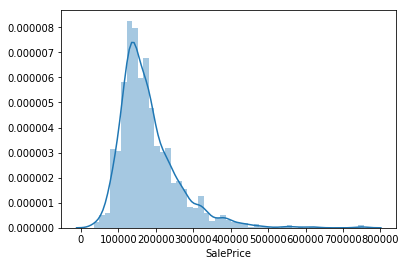

In [14]:
sns.distplot(train['SalePrice'])



On ne trouve pas une répartition "normale" des prix. On va donc normaliser y via une log transformation

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


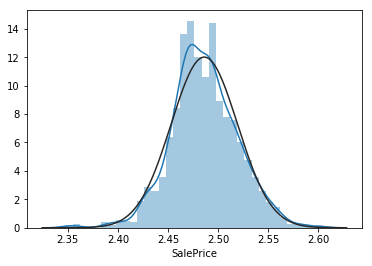

In [18]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)

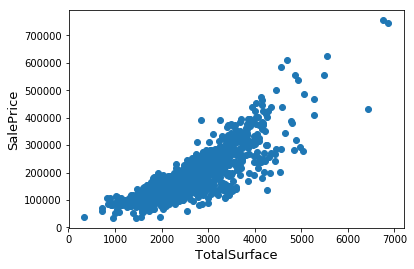

In [28]:
#On cherche la relation entre la superficie totale de la maison et le prix
train = train.drop(train[(train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']>7500) & (train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']<12000)].index)
#On enlève 2 points aberrants grâce à la ligne ci dessus

fig, ax = plt.subplots()
ax.scatter(x = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalSurface', fontsize=13)
plt.show()



La relation est bien linéaire entre les ces 2 quantités et on a retiré les 2 points qui semblaient aberrants 

On va dès à présent procéder au data preprocessing c'est à dire :
- parcourir les colonnes pour "nettoyer" et compléter les trous
- créer de nouvelles variables à partir de celles existantes
- éventuellement convertir des variables numériques en objet et vice versa + créer des dummies s'il le faut

In [36]:
#Missing values

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageType,81,0.055556
GarageCond,81,0.055556
GarageFinish,81,0.055556
GarageQual,81,0.055556


Il y a donc 19 variables où l'on va devoir travailler, ce sont celles présentées ci-dessus excepté "RoofMatl".
On les traiter dans l'ordre d'apparition dans le tableau.

In [42]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [43]:


all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")




In [44]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
YrSold,0,0.0
Foundation,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
Fence,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
FullBath,0,0.0


In [48]:
all_data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,1157.692492,335.861502,2.604045,2.860130,438.864930,49.599246,0.428865,0.061364,560.50360,23.114158,0.596160,1.567364,472.247515,1.765513,1870.270141,1498.251628,0.379842,1.044566,10139.439150,69.436064,4.697635,57.135756,100.931436,50.860816,6.213576,47.280082,5.564964,6.086390,2.088790,16.073363,6.448063,1048.967775,93.629414,1971.287967,1984.248200,2007.792938
std,385.264298,428.119663,25.196714,0.822967,444.180542,169.232130,0.523943,0.245687,439.69883,64.263424,0.644773,0.552465,214.762268,0.762102,449.826161,496.908626,0.502782,0.214532,7807.036512,21.208242,46.412570,42.532140,178.032499,567.595198,2.713070,67.118965,1.113414,1.406704,34.561371,56.202054,1.564281,429.472008,126.532643,30.286991,20.892257,1.315328
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,1300.000000,21.000000,0.000000,20.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.00000,0.000000,0.000000,1.000000,320.000000,1.000000,1957.000000,1126.000000,0.000000,1.000000,7476.000000,60.000000,0.000000,20.000000,0.000000,0.000000,4.000000,0.000000,5.000000,5.000000,0.000000,0.000000,5.000000,793.000000,0.000000,1953.000000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.00000,0.000000,1.000000,2.000000,480.000000,2.000000,1977.000000,1444.000000,0.000000,1.000000,9452.000000,70.000000,0.000000,50.000000,0.000000,0.000000,6.000000,26.000000,5.000000,6.000000,0.000000,0.000000,6.000000,988.000000,0.000000,1973.000000,1993.000000,2008.000000
75%,1384.000000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,804.00000,0.000000,1.000000,2.000000,576.000000,2.000000,2001.000000,1743.000000,1.000000,1.000000,11556.000000,80.000000,0.000000,70.000000,163.000000,0.000000,8.000000,70.000000,6.000000,7.000000,0.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,4010.000000,1526.000000,3.000000,2.000000,2336.00000,1012.000000,4.000000,4.000000,1488.000000,5.000000,2207.000000,5095.000000,2.000000,3.000000,215245.000000,313.000000,1064.000000,190.000000,1600.000000,17000.000000,12.000000,742.000000,9.000000,10.000000,800.000000,576.000000,15.000000,5095.000000,1424.000000,2010.000000,2010.000000,2010.000000


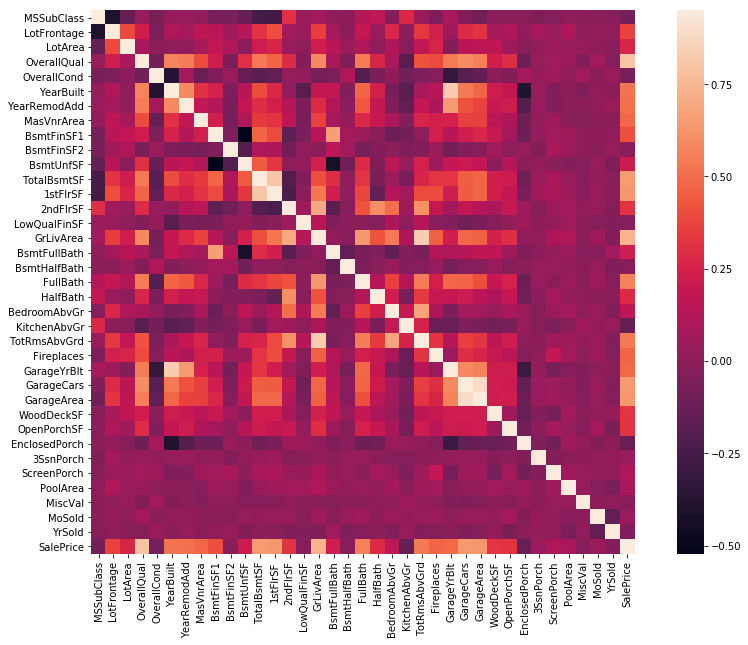

In [49]:
corrmat = train.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, vmax=0.95, square=True)

In [56]:
all_data = pd.get_dummies(all_data)

In [60]:
X = all_data[:ntrain]
test = all_data[ntrain:]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train,y_train)
reg.score(X_train,y_train)

0.3556579759091114